<a href="https://colab.research.google.com/github/piusAI/DeepLearning_Basic/blob/main/Chap05_05_Learn_Implement_from_Back_Propagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BackPropagation

### Prepration TwoLayerNet

#### def Function

In [ ]:
import numpy as np
import keras.datasets.mnist as mnist

mnist.load_data()

def sigmoid(x):
  return 1 / (1+ np.exp(-x))

def softmax(a):
  if a.ndim==2:
    a = a - np.max(a, axis=1, keepdims=1)
    y = np.exp(a) / np.sum(np.exp(a), axis=1, keepdims=1)
  else:
    a = a - np.max(a)
    y = np.exp(a) / np.sum(np.exp(a))
  return y

def CEE(y, t):
  if y.ndim==1:
    y = y.shape(1, -1)
    t = t.shape(1, -1)

  # if t.shape != y.shape:
  #   t = np.argmax(t, axis=1)

  batch_size = y.shape[0]
  loss = -np.log(np.sum( y[np.arange(batch_size),t]+1e-7 )) /batch_size
  return loss

# def _nobatch_numerical_gradient(f,x):
#   h = 1e-4
#   grad = np.zeros_like(x)
#   for idx in range(x.size):
#     tmp_val = x[idx]
#     x[idx] = float(tmp_val)+h
#     fxh1 = f(x)

#     x[idx] = tmp_val -h
#     fxh2 = f(x)
#     grad[idx] = (fxh1- fxh2) / 2* h
#     x[idx] = tmp_val
#   return grad


def _nobatch_numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]

        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f는 loss(x, t)

        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp_val
        it.iternext()

    return grad



def numerical_gradient(f,X):
  if X.ndim==1:
    return _nobatch_numerical_gradient(f,X)
  else:
    grad = np.zeros_like(X)
    for i, idx in enumerate(X):
      grad[i] = _nobatch_numerical_gradient(f,idx)
    return grad


#### Def Code - Relu, Affine, SoftmaxWithLoss - 따라침

In [ ]:
import numpy as np

class Relu:
  def __init__(self):
    self.mask = None

  def forward(self, x):
    self.mask = (x<=0)
    out = x.copy()
    out[self.mask] = 0
    return out

  def backward(self, dout):
    dout[self.mask]=0
    dx = dout

    return dx

class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b

    self.x = None
    self.original_x_shape = None

    self.dW = None
    self.db = None

  def forward(self, x):
    self.original_x_shape = x.shape
    x = x.reshape(x.shape[0], -1)

    self.x = x
    out = np.dot(self.x, self.W) + self.b

    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis=0)

    dx = dx.reshape(*self.original_x_shape)
    return dx

class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None
    self.y = None
    self.t = None

  def forward(self, x, t):
    self.t = t
    self.y = softmax(x)
    self.loss = CEE(self.y, self.t)

    return self.loss

  def backward(self, dout = 1):
    batch_size = self.t.shape[0]
    if self.t.size == self.y.size:
      dx = (self.y - self.t) / batch_size

    else :
      dx = self.y.copy()
      dx[np.arange(batch_size), self.t] -=1
      dx = dx/ batch_size
    return dx

위 코드 직접 구현 추후 해보기

### Implement TwoLayer Net

In [ ]:
from collections import OrderedDict

class TwolayerNet():
  def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
    self.params={}
    self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

    self.layers = OrderedDict()
    self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
    self.layers['Relu1'] = Relu()
    self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

    self.lastlayer = SoftmaxWithLoss() #따로 넣음

  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forward(x)
    return x
    # Call Score!
    # predict할때는, Train이 아니기 때문에, Softmax까지 갈 필요 없음
    ## => softmax는 단조 증가함수이기에 그저 커지기만함!

  def loss(self, x,t):
    y = self.predict(x)
    return self.lastlayer.forward(y,t)

  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    if t.ndim != 1 : t= np.argmax(t, axis=1)

    accuracy = np.sum(y==t) / float(x.shape[0])
    return accuracy

  def numerical_gradient(self, x, t):
    loss_w = lambda w: self.loss(x,t)
    grads={}
    grads['W1'] = numerical_gradient(loss_w, self.params['W1'])
    grads['b1'] = numerical_gradient(loss_w, self.params['b1'])
    grads['W2'] = numerical_gradient(loss_w, self.params['W2'])
    grads['b2'] = numerical_gradient(loss_w, self.params['b2'])

    return grads

  def gradient(self, x, t):
    self.loss(x,t)

    dout = 1
    dout = self.lastlayer.backward(dout)

    layers= list(self.layers.values()) # set the List Values of Layers [Affine1, Relu1, Affine2]
    layers.reverse() # Reverse Layers [Affine2, Relu1, Affine1]
    for layer in layers:
      dout = layer.backward(dout)

    grads={}
    grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
    grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
    #dW, db는 각각 Weight gradient, bias gradient!

    return grads

✅ 정리 요약

-

1.   역전파시, 순서가 중요하기떄문에 OrderedDiction으로!


➡ Affine1 => Relu1 => Affine2 이 순서가 중요!

2.   predict는 Softmax이전까지의 Forward(순전파)

3.   forward는 Affine.forward, Relu.forward의 순전파 Module

|||
|--|--|
| 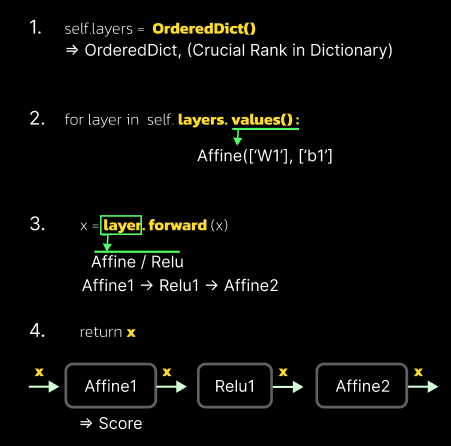| 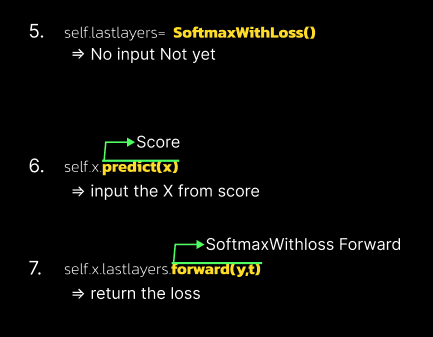|
|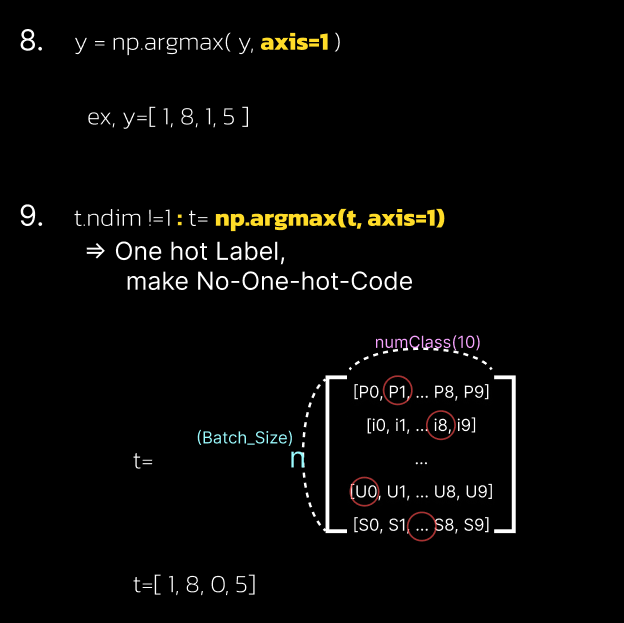|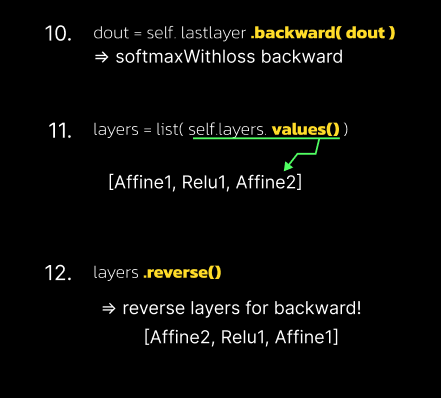|

In [ ]:
tl = TwolayerNet(input_size = 784, hidden_size = 50, output_size = 10)

print(tl.layers.values())
print(tl.layers.keys())

odict_values([<__main__.Affine object at 0x7e5618a61650>, <__main__.Relu object at 0x7e561a4bfe50>, <__main__.Affine object at 0x7e5613ff96d0>])
odict_keys(['Affine1', 'Relu1', 'Affine2'])


=> Key, Value를 확인할 수 있다

#### OrderedDictionary?

In [ ]:
from collections import OrderedDict

a = {'Pius' : "Ai", "JGAi" : "Soccer", "SaaS" : "Service"}
b = {"JGAi" : "Soccer", "SaaS" : "Service",'Pius' : "Ai" }

c=OrderedDict(a)
d=OrderedDict(b)

print(a==b)
print(c==d)

l_av=list(a.values())
l_ck=list(c.keys())

print(l_av)
print(l_ck)

print(l_ck.reverse())

True
False
['Ai', 'Soccer', 'Service']
['Pius', 'JGAi', 'SaaS']
None


- Dictionary는 순서에 구애 받지 않는 Key-Value.
- OrderDictionary는 순서에 구애 받는다.

In [ ]:
G = {1:"S",2:"i",3:"u",4:"u0"}
keys=list(OrderedDict(G).keys())
keys.reverse() # 바로 실행되어서 return None, 바로 print 불가

values=list(OrderedDict(G).values())
values.reverse()
print(values)
print(keys)

['u0', 'u', 'i', 'S']
[4, 3, 2, 1]


In [ ]:
X=np.random.randn(4,4)
X=X.reshape(1,-1)
print(X)

Y = list(X.flatten())
Y.reverse()
print(Y)

[[ 1.33485351 -0.56557682 -0.75752613  1.30819602  1.34722249  0.86163106
   0.20729667 -0.47095863 -0.81234116 -0.5079782   1.71646801  0.80812033
   0.62714675 -0.97205935  1.06317749  1.5593041 ]]
[np.float64(1.5593041034347286), np.float64(1.0631774942694248), np.float64(-0.9720593457029498), np.float64(0.6271467452883617), np.float64(0.808120332126001), np.float64(1.7164680095128189), np.float64(-0.5079782010104156), np.float64(-0.8123411628886149), np.float64(-0.4709586263724586), np.float64(0.20729666915814238), np.float64(0.8616310642892326), np.float64(1.3472224882653772), np.float64(1.3081960224757843), np.float64(-0.7575261346579595), np.float64(-0.5655768174700001), np.float64(1.3348535068549987)]


#### Implement Propagation ConCeptual Flow

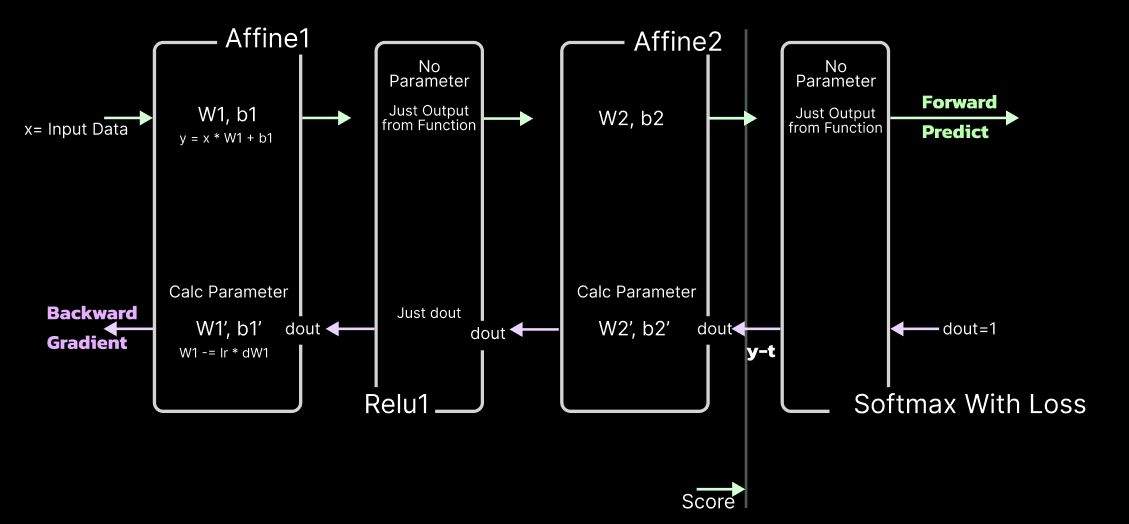

### mnist data Stochastic Gradient

In [163]:
from keras.datasets import mnist
import pickle

(x_train, t_train), (x_test, t_test) = mnist.load_data()

## reshape & nomralize
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test.reshape(-1, 784).astype('float32') / 255.0
## when DL Learn, must Do Normalize!!

network = TwolayerNet(input_size = 784, hidden_size = 50, output_size=10)
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list =[]
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1) #batch_size가 크면 1로 두도록

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.gradient(x_batch, t_batch)

    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    loss = network.loss(x_batch,t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch ==0: #600배수일때만 test!
        train_acc = network.accuracy(x_train, t_train) #batch아닌 Train으로 전체 data에다가!
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

'''
with open('neuralnet.pkl', 'wb') as f:
  pickle.dump(network.params.f)
  '''
### pickle dump! -- write binary

0.09773333333333334 0.103
0.9024166666666666 0.9047
0.9234833333333333 0.9225
0.9384 0.9382
0.9475666666666667 0.9461
0.9542666666666667 0.9519
0.9578333333333333 0.9551
0.9625 0.958
0.96625 0.962
0.9670166666666666 0.963
0.9709833333333333 0.9656
0.9722 0.9659
0.9728 0.9652
0.9756166666666667 0.9686
0.9758333333333333 0.9674
0.9769666666666666 0.9675
0.9790166666666666 0.9706


"\nwith open('neuralnet.pkl', 'wb') as f:\n  pickle.dump(network.params.f)\n  "

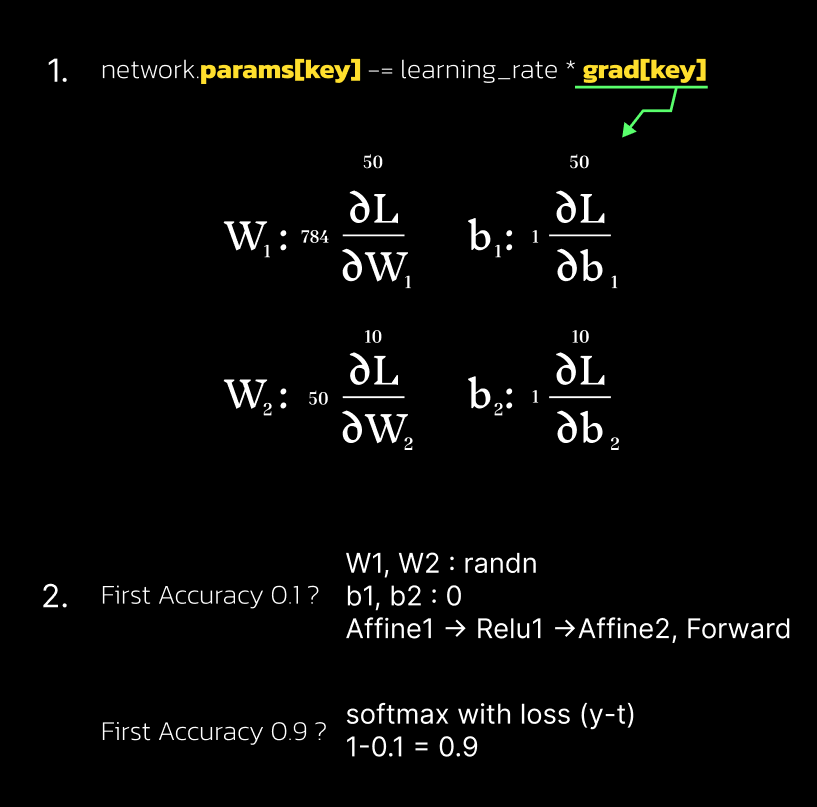

중복이 두번이 일어난다

In [ ]:
# 01. Random시 중복 피하는 방법
np.random.choice(5,3, replace=False)

array([4, 3, 1])

02. iteration가 돌아갈때 선택되는 Batch_mask들이 어쩔 수 없이 겹치게 된다.

### Gradient Check

In [161]:
from keras.datasets import mnist

(x_train, t_train), (x_test, t_test) = mnist.load_data()

x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test.reshape(-1, 784).astype('float32') / 255.0

network=TwolayerNet(input_size = 784, hidden_size = 50, output_size=10)

##
def to_one_hot(t, num_classes =10):
  if t.ndim ==1:
    one_hot = np.zeros((t.size, num_classes))
    one_hot[np.arange(t.size), t] = 1
    return one_hot
  return t
###### one- hot label
# => 사실 할필요 없음 numerical_gradient에서 nditer를 잡아주는게 더 중요!

x_batch = x_train[:3]
t_batch = t_train[:3]
# t_batch = to_one_hot(t_batch)

grad_numerical = network.numerical_gradient(x_batch, t_batch) # numerical로 구한 grad
grad_backprop = network.gradient(x_batch, t_batch) # 역전파로 구한 grad

#for key in grad: #이것도 가능 'W1', 'b1', 'W2', 'b2'사용하는건 동일하니까
for key in grad_numerical.keys():
  diff = np.average(np.abs(grad_backprop[key])- grad_numerical[key] )
  print(key + ':' + str(diff))

W1:0.0004888537981219075
b1:0.0032843893868048256
W2:0.0067739757578883205
b2:0.13996008825702888


```
for key in grad :
```
로도 가능!

'W1', 'b1', 'W2', 'b2'의 key인
grad를 사용하는것은 같기 때문에

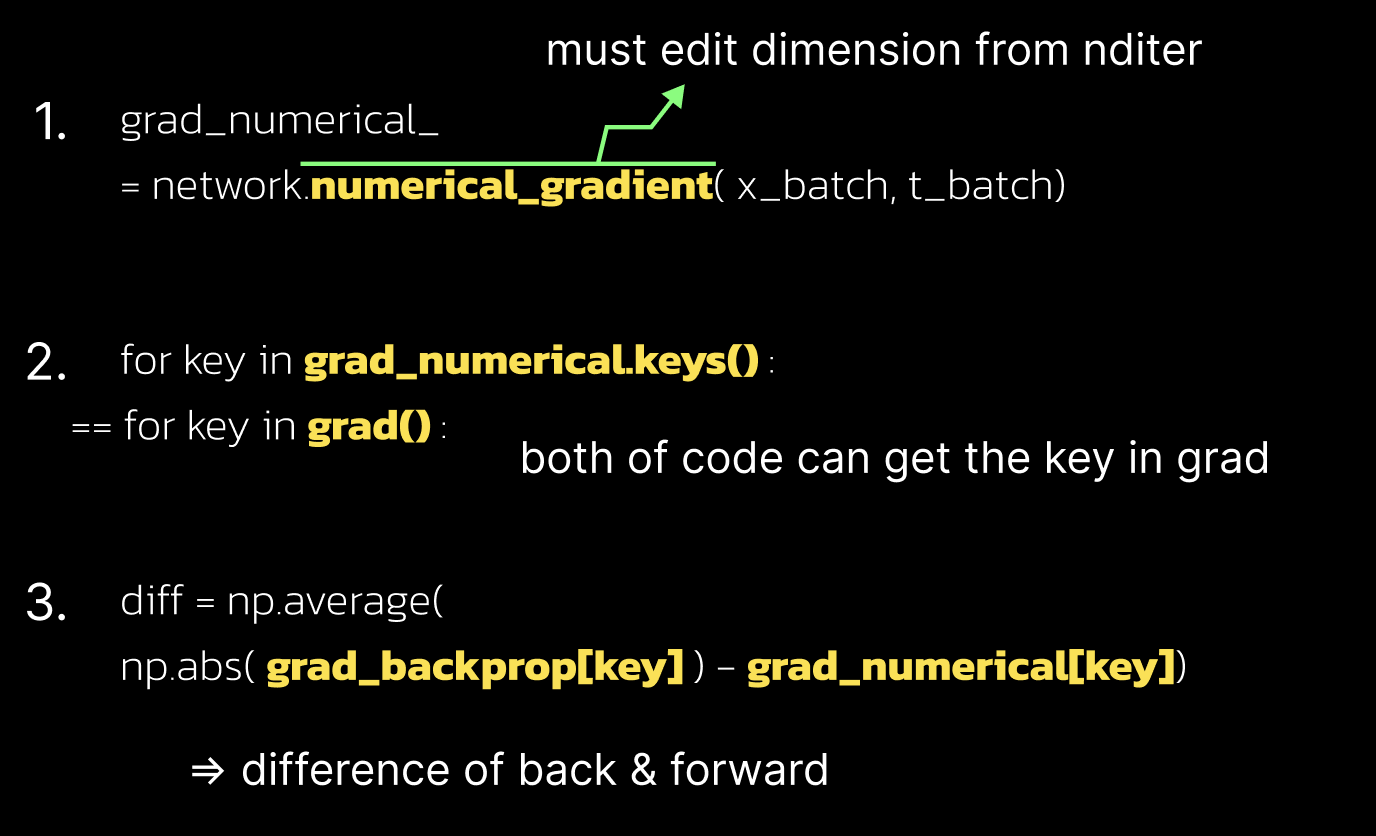

그냥 numerical_gradient에서는 오류가뜸!

dictionary 형태로 4개, W1, b1, W2, b2로 취함

#### nditer로의 numerical_gradient 수정

In [ ]:
def numerical_gradient(f, x):
  h= 1e-4
  grad = np.zeros_like(x)

  for i in range(x.size):
    tmp_val = x[i]
    x = float(tmp_val)+h
    fxh1 = f(x)

    x = tmp_val - h
    fxh2 = f(x)
    grad[i] = ( fxh1 - fxh2) / ( 2*h )
    x = tmp_val
  return grad


In [153]:
import numpy as np

pius = np.random.choice(29,6).reshape(2,3)
print(pius)
its = np.nditer(pius, flags=['multi_index'], op_flags=['readwrite'])
while not its.finished:
  idx = its.multi_index
  print(f'index : {idx}, value :{pius[idx]}')

  its.iternext()

print(its) #object of iterator

[[27 16 10]
 [25 19  9]]
index : (0, 0), value :27
index : (0, 1), value :16
index : (0, 2), value :10
index : (1, 0), value :25
index : (1, 1), value :19
index : (1, 2), value :9


In [ ]:

def Last_nobatch_numerical_gradient(f,x):
  h = 1e-4
  grad = np.zeros_like(x)

  itt= np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not itt.finished:
    idx = itt.multi_index
    tmp = x[idx]
    x[idx] = float(tmp) + h
    fxh1 = f(x)

    x[idx] = tmp - h
    fxh2 = f(x)

    grad[idx] = (fxh1 - fxh2) / (2 * h)
    x[idx] = tmp
    itt.iternext()
  return grad

def real_numerical_gradient(f,X):
  if X.ndim==1:
    return Last_nobatch_numerical_gradient(f,X)
  else :
    grad = np.zeros_like(X)
    for i, idx in enumerate(X):
      grad[i] = Last_nobatch_numerical_gradient(f, idx)
    return grad


x = np.arange(-5,5,0.1).flatten()

f= lambda t : np.sum(t**2+t+2)
gradi = real_numerical_gradient(f,x)
print(gradi)

[-9.  -8.8 -8.6 -8.4 -8.2 -8.  -7.8 -7.6 -7.4 -7.2 -7.  -6.8 -6.6 -6.4
 -6.2 -6.  -5.8 -5.6 -5.4 -5.2 -5.  -4.8 -4.6 -4.4 -4.2 -4.  -3.8 -3.6
 -3.4 -3.2 -3.  -2.8 -2.6 -2.4 -2.2 -2.  -1.8 -1.6 -1.4 -1.2 -1.  -0.8
 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.
  2.2  2.4  2.6  2.8  3.   3.2  3.4  3.6  3.8  4.   4.2  4.4  4.6  4.8
  5.   5.2  5.4  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4  7.6
  7.8  8.   8.2  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4
 10.6 10.8]


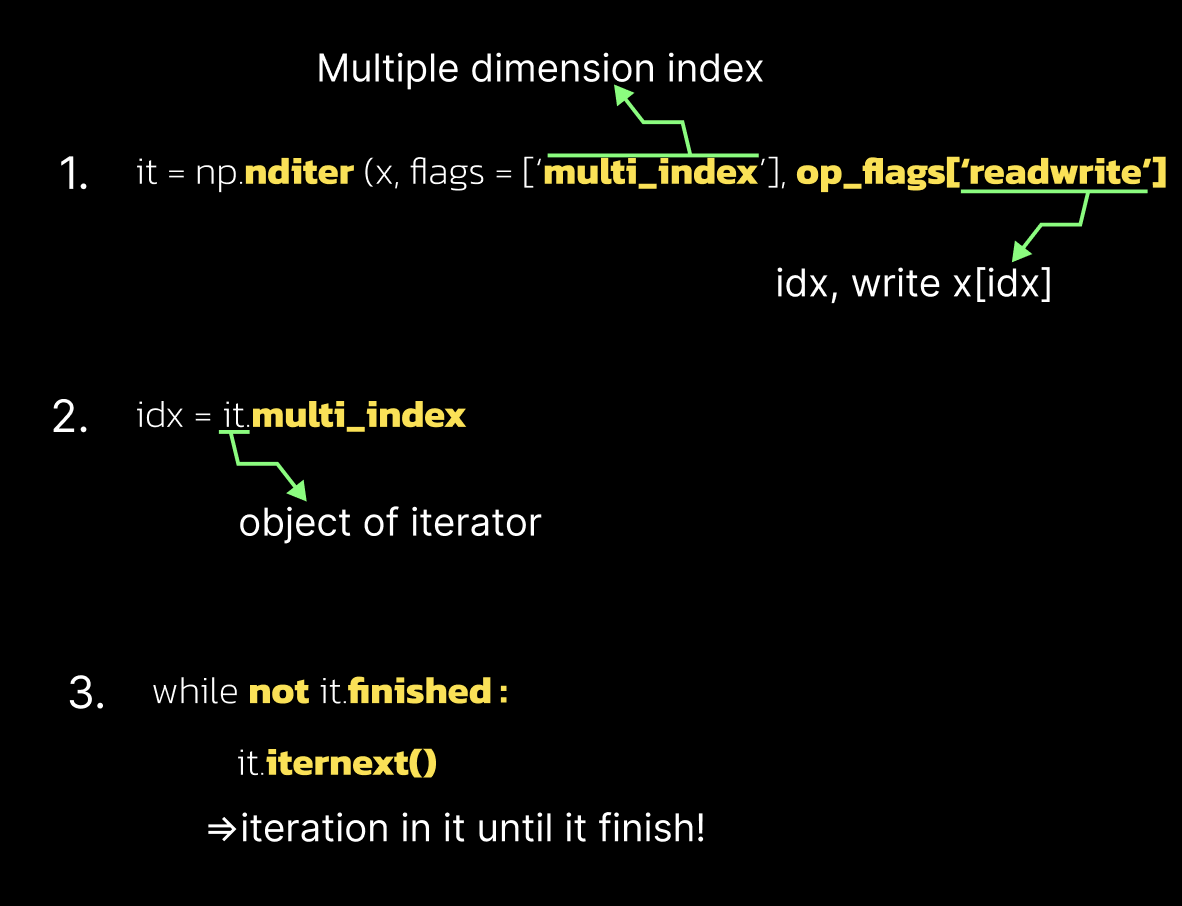

nditer로의 multi_index를 잡아서 numerical_gradient에 설정해줘야함.


| 이유                      | 설명                                           |
| ----------------------- | -------------------------------------------- |
| ✅ **다차원 배열** 지원         | 1D, 2D, 3D 어떤 배열도 안전하게 순회                    |
| ✅ **정확한 좌표 접근**         | `multi_index`로 정확한 인덱스 지정 가능                 |
| ✅ **값 수정 가능**           | `op_flags=['readwrite']`로 `x[idx]`에 직접 접근 가능 |
| ✅ **Gradient 계산 핵심 도구** | 각 요소에 대해 +h/-h 적용해 미분값 추출                    |
